In [90]:
import pandas as pd
import numpy as np
from datetime import datetime

In [91]:
today = datetime.today().strftime("%Y-%m-%d")

In [92]:
from urllib import request, parse
print("Today is", today)
# url =  "https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-%s.xlsx" % today
url = "https://opendata.ecdc.europa.eu/covid19/casedistribution/csv"
req =  request.Request(url) #, data=data) # this will make the method "POST"
resp = request.urlopen(req)
resp = resp.read()

Today is 2020-03-29


In [93]:
outfile = "ECDC_%s.csv" %today

In [94]:
with open(outfile, 'wb') as out_cvs:
    out_cvs.write(resp)

data= pd.read_csv(outfile, encoding='mac_roman')

data['dateRep'] = pd.to_datetime(data.dateRep)
data.rename(columns={'dateRep' : 'date'}, inplace=True)


data['geoId'] = (data.geoId)

data = data.sort_values(['geoId','date'])

In [95]:
cols_cum = ['cases','deaths']

for col in cols_cum:
    data[col+'_cum'] = data.groupby('geoId')[col].cumsum()

In [96]:
data = data[data.date <= today]

data = data.set_index('date')

In [97]:
import matplotlib
from matplotlib import pyplot as plt

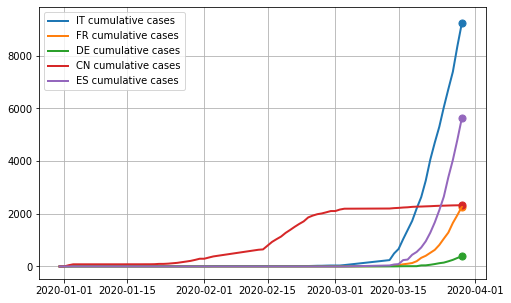

In [232]:
fig,ax = plt.subplots(figsize=(8,5))

for cntry in ['IT','FR','DE','CN','ES']:
    plt_data = data[data.geoId==cntry]
    latest_data = plt_data.loc[plt_data.index==max(plt_data.index)]
    ax.plot(plt_data.index, "deaths_cum", data=plt_data, label=cntry+' cumulative cases', linewidth=2)
    ax.scatter(x=latest_data.index, y=latest_data.deaths_cum, s=50)
    
ax.legend()
# ax.set_yscale('log')
ax.grid()   


In [99]:
data['cases_cum_lag'] = data.groupby('geoId')['cases_cum'].shift(-1)
data['deaths_cum_lag'] = data.groupby('geoId')['deaths_cum'].shift(-1)

In [100]:
cases_diff = data.groupby('geoId').apply(lambda x: x.cases_cum.shift(-1) - x.cases_cum).reset_index()

In [219]:
lag_dict = {}
for cntry in data.geoId.unique():
    #df = cases_diff[cases_diff.geoId == cntry].set_index('date')
    df = data[data.geoId==cntry]#.set_index('date')
    #df = df[df.index > '2020-02-20'].deaths >50
    df = df.deaths_cum >50
#     df = df.cases_cum > 200
    try:
        lag_date = df[df==True].index[0]
        tmp = {cntry : lag_date}
        lag_dict.update(tmp)
        print(cntry, 'OK')
    except:
        print(cntry, 'Not above threshold')

AD Not above threshold
AE Not above threshold
AF Not above threshold
AG Not above threshold
AI Not above threshold
AL Not above threshold
AM Not above threshold
AO Not above threshold
AR Not above threshold
AT OK
AU Not above threshold
AW Not above threshold
AZ Not above threshold
BA Not above threshold
BB Not above threshold
BD Not above threshold
BE OK
BF Not above threshold
BG Not above threshold
BH Not above threshold
BJ Not above threshold
BM Not above threshold
BN Not above threshold
BO Not above threshold
BR OK
BS Not above threshold
BT Not above threshold
BY Not above threshold
BZ Not above threshold
CA OK
CD Not above threshold
CF Not above threshold
CG Not above threshold
CH OK
CI Not above threshold
CL Not above threshold
CM Not above threshold
CN OK
CO Not above threshold
CR Not above threshold
CU Not above threshold
CV Not above threshold
CW Not above threshold
CY Not above threshold
CZ Not above threshold
DE OK
DJ Not above threshold
DK OK
DM Not above threshold
DO Not ab

In [220]:
#lag_dict['CN'] = pd.to_datetime('2019-12-31')

In [221]:
df = pd.DataFrame()
for cntry in ['IT','FR','DE','CN','ES']:
    xx = data[(data.index == lag_dict[cntry]) & (data.geoId==cntry)]
    df=df.append(xx)
    
df

,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,cases_cum,deaths_cum,cases_cum_lag,deaths_cum_lag,t
date,,,,,,,,,,,,,,
2020-03-03,3,3,2020,146,17,Italy,IT,ITA,6.043128e+07,1835,52,4486.0,241.0,6 days
2020-03-16,16,3,2020,924,36,France,FR,FRA,6.698724e+07,3315,82,4525.0,103.0,2 days
2020-03-22,22,3,2020,3276,22,Germany,DE,DEU,8.292792e+07,20047,64,23358.0,91.0,2 days
2020-01-03,1,3,2020,574,35,China,CN,CHN,1.392730e+09,2696,81,2696.0,81.0,1 days
2020-03-14,14,3,2020,1227,37,Spain,ES,ESP,4.672375e+07,2204,74,3726.0,89.0,1 days


In [222]:
for cntry in ['IT','FR','DE','CN','ES']:
    lag_date = lag_dict[cntry]
    start_date = min(data.index)
#     len_cntry = data.loc[(data.index>=lag_date) & (data.index < today) & (data.geoId==cntry)].shape[0]
    print("country = ", cntry)
    print("lag_date: ", lag_date)
    data.loc[(data.index>=start_date) & (data.index < today) & (data.geoId==cntry), 't'] = \
            data.loc[(data.index>=start_date) & (data.index < today) & (data.geoId==cntry)].index-lag_date

country =  IT
lag_date:  2020-03-03 00:00:00
country =  FR
lag_date:  2020-03-16 00:00:00
country =  DE
lag_date:  2020-03-22 00:00:00
country =  CN
lag_date:  2020-01-03 00:00:00
country =  ES
lag_date:  2020-03-14 00:00:00


In [223]:
xx = data[data.geoId=='ES']

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  del sys.path[0]


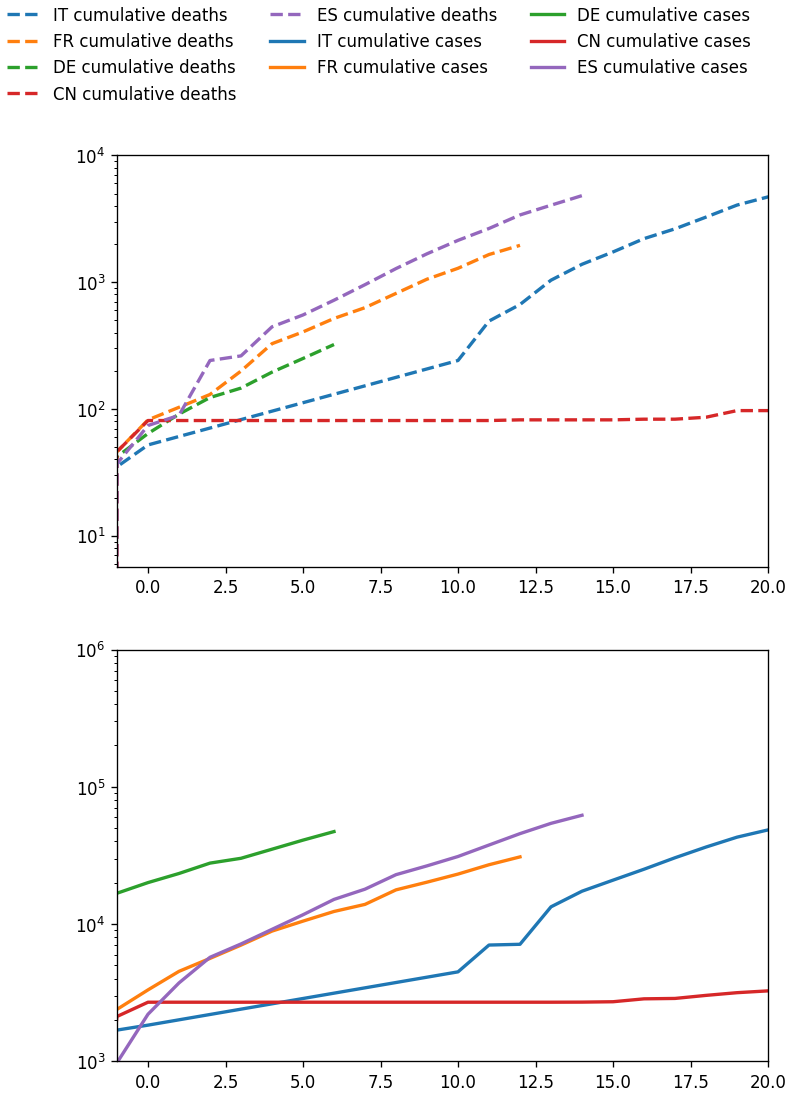

In [233]:
fig,(ax0,ax1) = plt.subplots(2,1,dpi=120, figsize=(7,10))

for cntry in ['IT','FR','DE','CN','ES']:
    plt_data = data[data.geoId==cntry]
    ax0.plot(plt_data.t.dt.days, "deaths_cum", data=plt_data, label=cntry+' cumulative deaths', 
             linewidth=2, linestyle='dashed')
#     ax0.scatter(x=max(plt_data.t.dt.days), y=plt_data.deaths_cum, s=50)
    
    ax1.plot(plt_data.t.dt.days, "cases_cum", data=plt_data, label=cntry+' cumulative cases', linewidth=2)
    ax0.set_yscale('log')
    
    ax0.set_xlim(-1,20)
    ax0.set_ylim(0,1e4)
    
    ax1.set_yscale('log')
    ax1.set_xlim(-1,20)
    ax1.set_ylim(1e3,1e6)


fig.legend(loc='upper left', ncol=3, #bbox_to_anchor=(0.1, 1.01), 
       borderaxespad=0, frameon=False
      )
#     ax0.legend()
#     ax0.grid()   

## Smoothed values

Applied a moving average on the cumlative deaths, to smooth the curves

In [79]:
data_main = data[(data.geoId.isin(['IT','FR','DE','CN','ES']))].copy()

data_main = data_main[['geoId','cases','deaths','cases_cum','deaths_cum','t']]

data_main['t'] = data_main.t.dt.days

data_main['cases_mav'] = data_main.cases_cum.rolling(5).mean()
data_main['deaths_mav'] = data_main.deaths_cum.rolling(5).mean()

In [ ]:
def running_mean(x, N):
    cumsum = numpy.cumsum(numpy.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [144]:
x=[6,1,2,3]

In [145]:
np.insert(x, 0, 0)

array([0, 6, 1, 2, 3])

In [147]:
cumsum = np.cumsum(np.insert(x, 0, 0)) 

In [150]:
cumsum - cumsum[:-N]

array([ 0,  6,  7,  9, 12])

In [152]:
cumsum[:-N]

array([0, 6, 7])

In [151]:
N=2
cumsum[N:]-cumsum[:-N]

array([7, 3, 5])

In [ ]:
(cumsum[N:] - cumsum[:-N]) / float(N)

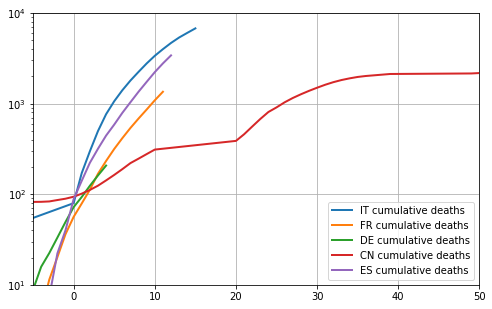

In [84]:
fig,ax = plt.subplots(figsize=(8,5))

for cntry in ['IT','FR','DE','CN','ES']:
    plt_data = data_main[data_main.geoId==cntry]
#     latest_data = plt_data.loc[plt_data.index==max(plt_data.index)]
    ax.plot(plt_data.t, "deaths_mav", data=plt_data, label=cntry+' cumulative deaths', linewidth=2)
#     ax.scatter(x=latest_data.index, y=latest_data.deaths_cum, s=50)
    plt.xlim(-5,50)
    plt.ylim(10,10**4)
    plt.yscale('log')
ax.legend()
ax.grid()   

In [228]:
a = pd.read_csv("/Users/vittorio/Downloads/time_series_covid19_confirmed_global.csv")

In [230]:
a[a['Country/Region']=='Italy'].pivot_table()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20
137,NaN,Italy,43.0,12.0,0,0,0,0,0,0,...,80589,86498,92472,97689,101739,105792,110574,115242,119827,124632
